In [57]:
import numpy as np
from qiskit import *
from qiskit import Aer
from scipy.optimize import minimize
import pandas as pd
from qiskit.test.mock import *
from qiskit.providers.aer import AerSimulator
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from functools import partial
import itertools
import mitiq
from cmaes import CMA
import cma
from qiskit.tools.monitor import job_monitor
from qiskit import IBMQ
import random
import re

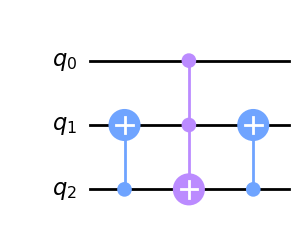

In [55]:
swap_circ = QuantumCircuit(3)
swap_circ.cswap(0, 1, 2)
swap_circ.decompose().draw(output='mpl')

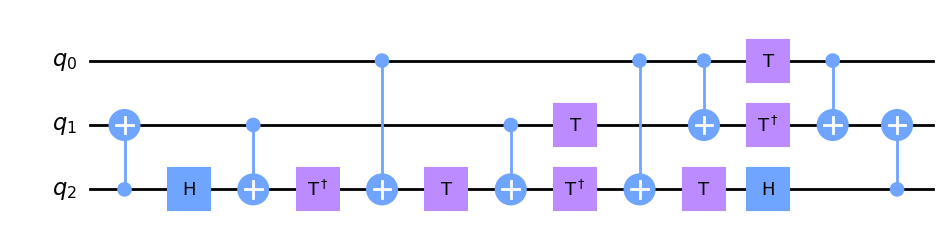

In [56]:
swap_circ = QuantumCircuit(3)
swap_circ.cnot(2, 1)
swap_circ.ccx(0, 1, 2)
swap_circ.cnot(2, 1)
swap_circ.decompose().draw(output='mpl')

### So you need 8 CNOTs to perform one CSWAP instruction.
### If you way to swap an arbitrary state |\Psi> and |\Phi> each with $L$ qubits, then you'll need $O(n)$ CSWAPs
### So you'll need $\leq 8L$ CNOTs to perform the controlled swap between the two states

------------------

### For integrable model there are $L$ Heisenberg terms. So we need $L$ $N$ circuits, below.
### Each $N$ circuit has 3 CNOTs and 8 gates total.
### Thus total number of CNOTs needed for one Trotter/Ansatz step is $L \times 3$, and the total number of gates is $L\times 8$ (ignoring initialization and ending swaps)

In [53]:
L = 3

def TwirlCircuit(circ):
    def apply_pauli(num, qb):
        if (num == 0):
            return f'id q[{qb}];\n'
        elif (num == 1):
            return f'x q[{qb}];\n'
        elif (num == 2):
            return f'y q[{qb}];\n'
        else:
            return f'z q[{qb}];\n'

    paulis = [(i,j) for i in range(0,4) for j in range(0,4)]
    paulis.remove((0,0))
    paulis_map = [(0, 1), (3, 2), (3, 3), (1, 1), (1, 0), (2, 3), (2, 2), (2, 1), (2, 0), (1, 3), (1, 2), (3, 0), (3, 1), (0, 2), (0, 3)]
    new_circ = ''
    ops = circ.qasm().splitlines(True)
    for op in ops:
        if (op[:2] == 'cx'): # can add for cz, etc.
            num = random.randrange(len(paulis))
            num = 5
            qbs = re.findall('q\[(.)\]', op)
            new_circ += apply_pauli(paulis[num][0], qbs[0])
            new_circ += apply_pauli(paulis[num][1], qbs[1])
            new_circ += op
            new_circ += apply_pauli(paulis_map[num][0], qbs[0])
            new_circ += apply_pauli(paulis_map[num][1], qbs[1])
        else:
            new_circ += op
    return qiskit.circuit.QuantumCircuit.from_qasm_str(new_circ)

def TrotterEvolveCircuit(dt, nt, init):
    """
    Implements trotter evolution of the Heisenberg hamiltonian using the circuit from https://arxiv.org/pdf/1906.06343.pdf
    :param tf: time to evolve to
    :param nt: number of trotter steps to use
    :param init: initial state for the trotter evolution. Should be another Qiskit circuit
    """

    # def get_angles(a, b, c):
    #     return (np.pi/2 - 2*c, 2*a - np.pi/2, np.pi/2 - 2*b)
    def get_angles(a):
        return (np.pi/2 - 2*a, 2*a - np.pi/2, np.pi/2 - 2*a)

    def N(circ, qb0, qb1):
        circ.rz(-np.pi/2, qb1)
        circ.cnot(qb1, qb0)
        circ.rz(theta, qb0)
        circ.ry(phi, qb1)
        circ.cnot(qb0, qb1)
        circ.ry(lambd, qb1)
        circ.cnot(qb1, qb0)
        circ.rz(np.pi/2, qb0)
        return circ

    theta, phi, lambd = get_angles(-dt/4)
    circ = init

    for i in range(nt):
        # even (odd indices)
        if (L % 2 == 0):
            # UEven
            for i in range(1, L-1, 2): # L for periodic bdy conditions
                circ = N(circ, i, (i+1)%L)
            # UOdd
            for i in range(0, L-1, 2):
                circ = N(circ, i, (i+1)%L)
        else:
            # UEven
            for i in range(1, L, 2):
                circ = N(circ, i, (i+1)%L)
            # UOdd
            for i in range(0, L-1, 2):
                circ = N(circ, i, (i+1)%L)
            # UBdy
            # circ = N(circ, L-1, 0)
    
    return circ

def AnsatzCircuit(params, p):
    """
    Implements HVA ansatz using circuits from https://arxiv.org/pdf/1906.06343.pdf
    :param params: parameters to parameterize circuit
    :param p: depth of the ansatz
    """
    circ = QuantumCircuit(L)

    def get_angles(a):
        return (np.pi/2 - 2*a, 2*a - np.pi/2, np.pi/2 - 2*a)

    def N(cir, angles, qb0, qb1):
        cir.rz(-np.pi/2, qb1)
        cir.cnot(qb1, qb0)
        cir.rz(angles[0], qb0)
        cir.ry(angles[1], qb1)
        cir.cnot(qb0, qb1)
        cir.ry(angles[2], qb1)
        cir.cnot(qb1, qb0)
        cir.rz(np.pi/2, qb0)
        return cir

    for i in range(p):
        if (L % 2 == 0):
            for j in range(1, L-1, 2): # L for periodic bdy conditions
                circ = N(circ, get_angles(-params[((L-1)*i)+j]/4), j, (j+1)%L)
            for j in range(0, L-1, 2):
                circ = N(circ, get_angles(-params[((L-1)*i)+j]/4), j, (j+1)%L)
        else:
            for j in range(1, L, 2):
                circ = N(circ, get_angles(-params[((L-1)*i)+j]/4), j, (j+1)%L)
            for j in range(0, L-1, 2):
                circ = N(circ, get_angles(-params[((L-1)*i)+j]/4), j, (j+1)%L)
            # circ = N(circ, get_angles(-params[(L*i)+L-1]/4), L-1, 0) # boundary
    return circ

def ReorderBasis(circ):
    """
    Reorders basis so that 0th qubit is on the left side of the tensor product
    :param circ: circuit to reorder, can also be a vector
    """
    if (isinstance(circ, qiskit.circuit.quantumcircuit.QuantumCircuit)):
        for i in range(L//2):
            circ.swap(i, L-i-1)
        return circ
    else:
        perm = np.eye(2**L)
        for i in range(1, 2**L//2):
            perm[:, [i, 2**L-i-1]] = perm[:, [2**L-i-1, i]]
        return perm @ circ

def SimulateAndReorder(circ):
    """
    Executes a circuit using the statevector simulator and reorders basis to match with standard
    """
    circ = ReorderBasis(circ)
    backend = Aer.get_backend('statevector_simulator')
    return execute(circ, backend).result().get_statevector()

def Simulate(circ):
    """
    Executes a circuit using the statevector simulator. Doesn't reorder -- which is needed for intermediate steps in the VTC
    """
    backend = Aer.get_backend('statevector_simulator')
    return execute(circ, backend).result().get_statevector()

def SwapTestCircuit(params, U_v, U_trot, init, p):
    """
    Cost function using the swap test. 
    :param params: parameters new variational circuit that represents U_trot U_v | init >. Need dagger for cost function
    :param U_v: variational circuit that stores the state before the trotter step
    :param U_trot: trotter step
    :param init: initial state
    :param p: number of ansatz steps
    :param shots: number of measurements to take
    """
    U_v_prime = init + AnsatzCircuit(params, p)
    U_v_prime = U_v_prime.qasm()
    U_v_prime = U_v_prime.replace(f'q[{L}]', f'q[{2*L+1}]')

    for i in range(L, -1, -1):
        U_v_prime = U_v_prime.replace(f'q[{i}]', f'q[{i+1}]')
    U_v_prime = circuit.QuantumCircuit.from_qasm_str(U_v_prime)

    comp = init + U_v + U_trot
    comp = comp.qasm()
    comp = comp.replace(f'q[{L}]', f'q[{2*L+1}]')
    for i in range(L, -1, -1):
        comp = comp.replace(f'q[{i}]', f'q[{L+i+1}]')
    comp = circuit.QuantumCircuit.from_qasm_str(comp)

    circ = QuantumCircuit(2*L+1, 1)
    circ.h(0)
    circ += U_v_prime 
    circ += comp

    # controlled swaps
    for i in range(L):
        circ.cswap(0, i+1, L+i+1)
    circ.h(0)
    circ.measure(0,0)

    return circ

def SwapTestExecutor(circuits, backend, shots, filter):
    scale_factors = [1.0, 2.0, 3.0]
    folded_circuits = []
    for circuit in circuits:
        folded_circuits.append([mitiq.zne.scaling.fold_gates_at_random(circuit, scale) for scale in scale_factors])
    folded_circuits = list(itertools.chain(*folded_circuits))

    job = qiskit.execute(
        experiments=folded_circuits,
        backend=backend,
        optimization_level=0,
        shots=shots
    )

    res = job.result()
    if (filter is not None):
        res = filter.apply(res)
    c = [str((1 + (-1)**(i+1)) // 2) for i in range(L)]
    c = ''.join(c)[::-1]

    all_counts = [job.result().get_counts(i) for i in range(len(folded_circuits))]
    expectation_values = []
    for counts in all_counts:
        if counts.get('0') is None:
            expectation_values.append(0)
        else:
            expectation_values.append(counts.get('0')/shots)

    zero_noise_values = []
    if isinstance(backend, qiskit.providers.aer.backends.qasm_simulator.QasmSimulator): # exact_sim
        for i in range(len(circuits)):
            zero_noise_values.append(np.mean(expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))
    else: #device_sim
        fac = mitiq.zne.inference.RichardsonFactory(scale_factors)
        for i in range(len(circuits)):
            zero_noise_values.append(fac.extrapolate(scale_factors, 
            expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))

    return zero_noise_values

    
def SwapTest(params, U_v, U_trot, init, p, backend, shots, filter):
    """

    """
    circs = []
    for param in params:
        circs.append(SwapTestCircuit(param, U_v, U_trot, init, p))
    res = SwapTestExecutor(circs, backend, shots, filter)
    return abs(1 - np.array(res))

def LoschmidtEchoExecutor(circuits, backend, shots, filter):
    """
    Returns the expectation value to be mitigated.
    :param circuit: Circuit to run.
    :param backend: backend to run the circuit  on
    :param shots: Number of times to execute the circuit to compute the expectation value.
    :param fitter: measurement error mitigator
    """
    scale_factors = [1.0, 2.0, 3.0]
    folded_circuits = []
    for circuit in circuits:
        folded_circuits.append([mitiq.zne.scaling.fold_gates_at_random(circuit, scale) for scale in scale_factors])
    folded_circuits = list(itertools.chain(*folded_circuits))

    job = qiskit.execute(
        experiments=folded_circuits,
        backend=backend,
        optimization_level=0,
        shots=shots
    )

    # job_monitor(job)

    c = [str((1 + (-1)**(i+1)) // 2) for i in range(L)]
    c = ''.join(c)[::-1]
    res = job.result()
    if (filter is not None):
        res = filter.apply(res)

    all_counts = [job.result().get_counts(i) for i in range(len(folded_circuits))]
    expectation_values = []
    for counts in all_counts:
        if counts.get(c) is None:
            expectation_values.append(0)
        else:
            expectation_values.append(counts.get(c)/shots)
    
    zero_noise_values = []
    if isinstance(backend, qiskit.providers.aer.backends.qasm_simulator.QasmSimulator): # exact_sim
        for i in range(len(circuits)):
            zero_noise_values.append(np.mean(expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))
    else: #device_sim
        fac = mitiq.zne.inference.RichardsonFactory(scale_factors)
        for i in range(len(circuits)):
            zero_noise_values.append(fac.extrapolate(scale_factors, 
            expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))

    return zero_noise_values

def LoschmidtEchoCircuit(params, U_v, U_trot, init, p):
    """
    Cost function using the Loschmidt Echo. Just using statevectors currently -- can rewrite using shots
    :param params: parameters new variational circuit that represents U_trot U_v | init >. Need dagger for cost function
    :param U_v: variational circuit that stores the state before the trotter step
    :param U_trot: trotter step
    :param init: initial state
    :param p: number of ansatz steps
    """
    U_v_prime = AnsatzCircuit(params, p)
    circ = init + U_v + U_trot + U_v_prime.inverse()
    circ.measure_all()
    return circ

def LoschmidtEcho(params, U_v, U_trot, init, p, backend, shots, filter):
    """

    """
    circs = []
    for param in params:
        circs.append(LoschmidtEchoCircuit(param, U_v, U_trot, init, p))
    res = LoschmidtEchoExecutor(circs, backend, shots, filter)
    return 1 - np.array(res)

def LoschmidtEchoExact(params, U_v, U_trot, init, p):
    U_v_prime = AnsatzCircuit(params, p)
    circ = init + U_v + U_trot + U_v_prime.inverse()

    circ_vec = Simulate(circ)
    init_vec = Simulate(init)
    return 1 - abs(np.conj(circ_vec) @ init_vec)**2

def CMAES(U_v, U_trot, init, p, backend, shots, filter):
    init_params = np.random.uniform(0, 2*np.pi, (L-1)*p)
    es = cma.CMAEvolutionStrategy(init_params, np.pi/2)
    es.opts.set({'ftarget':1e-11, 'maxiter':100}) #ftarget
    while not es.stop():
        solutions = es.ask()
        es.tell(solutions, SwapTest(solutions, U_v, U_trot, init, p, backend, shots, filter))
        es.disp()
    return es.result_pretty()

def VTC(tf, dt, p, init):
    """
    :param init: initial state as a circuit
    """
    nt = int(np.ceil(tf / (dt * p)))

    VTCParamList = []
    VTCStepList = [SimulateAndReorder(init.copy())]
    TrotterFixStepList = [init]
    TimeStep = [0]

    for i in range(nt):
        print(i, nt)
        if (i == 0):
            U_v = QuantumCircuit(L)
        else:
            U_v = AnsatzCircuit(VTCParamList[-1], p)
        U_trot = TrotterEvolveCircuit(dt, p, QuantumCircuit(L))
        
        TrotterFixStepList.append(TrotterFixStepList[-1] + U_trot)
        
        # init_params = np.random.uniform(0, np.pi, (L-1)*p)
        # res = minimize(fun=SwapTest, x0=init_params, args=(U_v, U_trot, init, p, 8192), method='COBYLA')
        # res = minimize(fun=LoschmidtEcho, x0=init_params, args=(U_v, U_trot, init, p, exact_sim, 8192, None), method='COBYLA')
        # res = minimize(fun=LoschmidtEchoExact, x0=init_params, args=(U_v, U_trot, init, p))
        # res = [0, 1]
        # while (res[1] > 0.05):
        res = CMAES(U_v, U_trot, init, p, exact_sim, 8192, None)

        print(res)
        
        VTCParamList.append(res.xbest) #res.x
        VTCStepList.append(SimulateAndReorder(init + AnsatzCircuit(res.xbest, p))) #res.x
        TimeStep.append(TimeStep[-1]+(dt*p))
    
    TrotterFixStepList = pd.DataFrame(np.array([SimulateAndReorder(c.copy()) for c in TrotterFixStepList]), index=np.array(TimeStep))
    VTCParamList = pd.DataFrame(np.array(VTCParamList), index=np.array(TimeStep[1:]))
    VTCStepList = pd.DataFrame(np.array(VTCStepList), index=np.array(TimeStep))

    TrotterFixStepList.to_csv(f'./VTD_results/VTD_results_{tf}_{L}_{p}_{dt}.csv')


In [4]:
# provider = IBMQ.load_account()

qr = QuantumRegister(L)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

device_backend = FakeSantiago()
device_sim = AerSimulator.from_backend(device_backend)
exact_sim = Aer.get_backend('qasm_simulator')
sim = device_sim

# Execute the calibration circuits without noise
t_qc = transpile(meas_calibs, sim)
qobj = assemble(t_qc, shots=10000)
cal_results = sim.run(qobj, shots=10000).result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
# np.around(meas_fitter.cal_matrix, decimals=2)

# real_device = provider.get_backend('ibmq_santiago')

In [5]:
p = 2

init = QuantumCircuit(L)
# c = [str((1 + (-1)**(i+1)) // 2) for i in range(L)]
c = ['1','1','0']
for q in range(len(c)):
    if (c[q] == '1'):
        init.x(q)

# VTC(20, 1, p, init)


In [7]:
num_generations = 10
optimizer = CMA(mean=np.ones(p*(L-1))*0, sigma=np.pi/4)

U_v = QuantumCircuit(L)
# U_v = AnsatzCircuit(np.array([-8.30626975, -9.81312414]), p)
U_trot = TrotterEvolveCircuit(1, 2, QuantumCircuit(L))

# for generation in range(num_generations):
#     print('.', end='')
#     solutions = []
#     params = []
#     for _ in range(optimizer.population_size):
#         x = optimizer.ask()
#         params.append(x)
#     values = LoschmidtEcho(params, U_v, U_trot, init, p, exact_sim, 8192, None)
#     for i in range(optimizer.population_size):
#         solutions.append((params[i], values[i]))
#     optimizer.tell(solutions)
# solutions

In [ ]:
cma.__version__

In [ ]:
init_params = np.random.uniform(0, np.pi, (L-1)*p)
es = cma.CMAEvolutionStrategy(init_params, np.pi/2, {'ftarget':5e-3})
while not es.stop():
    solutions = es.ask(25)
    print(len(solutions))
    es.tell(solutions, LoschmidtEcho(solutions, U_v, U_trot, init, p, device_sim, 8192, meas_fitter.filter))
    es.logger.add()
    es.disp()

In [ ]:
p = 2
# U_v = AnsatzCircuit(np.array([-8.30626975, -9.81312414]), p)#QuantumCircuit(L)
U_v = QuantumCircuit(L)
U_trot = TrotterEvolveCircuit(1, 2, QuantumCircuit(L))
# U_trot = QuantumCircuit(L)
init_params = np.random.uniform(0, np.pi, (L-1)*p)
# res = minimize(fun=LoschmidtEcho, x0=init_params, args=(U_v, U_trot, init, p, exact_sim, 8192, None), method='COBYLA')
# res = minimize(fun=SwapTest, x0=init_params, args=(U_v, U_trot, init, p, exact_sim, 8192, None), method='COBYLA')
res = minimize(fun=LoschmidtEchoExact, x0=init_params, args=(U_v, U_trot, init, p))


# circ = LoschmidtEcho(init_params, U_v, U_trot, init, p, 1024)
res

In [ ]:
circ = LoschmidtEchoCircuit(res.x, U_v, U_trot, init, p)
exact_res = LoschmidtEchoExecutor(circ, exact_sim, 10000, None)
noisy_res = LoschmidtEchoExecutor(circ, device_sim, 10000, None)
mit_res = mitiq.zne.execute_with_zne(circ, partial(LoschmidtEchoExecutor, backend=device_sim, shots=10000, filter=None))
mit_meas_res = mitiq.zne.execute_with_zne(circ, partial(LoschmidtEchoExecutor, backend=device_sim, shots=10000, filter=meas_fitter.filter)) 
mit_meas = LoschmidtEchoExecutor(circ, device_sim, 10000, meas_fitter.filter)

print(f"Error without mitigation: {abs(exact_res - noisy_res):.{3}}")
print(f"Error with mitigation (ZNE): {abs(exact_res - mit_res):.{3}}")
print(f"Error with mitigation (ZNE and meas): {abs(exact_res - mit_meas_res):.{3}}")
print(f"Error with mitigation (meas): {abs(exact_res - mit_meas):.{3}}")

In [9]:
trot = init + U_trot
ansz = init + AnsatzCircuit(np.array([1.39095993,  5.16185346,  4.84382838, -2.17615697]), p)
# ansz.draw(output='mpl')
ansz.qasm()

'OPENQASM 2.0;\ninclude "qelib1.inc";\nqreg q[3];\nx q[0];\nx q[1];\nrz(-pi/2) q[2];\ncx q[2],q[1];\nrz(4.1517231) q[1];\nry(-4.1517231) q[2];\ncx q[1],q[2];\nry(4.1517231) q[2];\ncx q[2],q[1];\nrz(pi/2) q[1];\nrz(-pi/2) q[1];\ncx q[1],q[0];\nrz(2.2662763) q[0];\nry(-2.2662763) q[1];\ncx q[0],q[1];\nry(2.2662763) q[1];\ncx q[1],q[0];\nrz(pi/2) q[0];\nrz(-pi/2) q[2];\ncx q[2],q[1];\nrz(0.48271784) q[1];\nry(-0.48271784) q[2];\ncx q[1],q[2];\nry(0.48271784) q[2];\ncx q[2],q[1];\nrz(pi/2) q[1];\nrz(-pi/2) q[1];\ncx q[1],q[0];\nrz(3.9927105) q[0];\nry(-3.9927105) q[1];\ncx q[0],q[1];\nry(3.9927105) q[1];\ncx q[1],q[0];\nrz(pi/2) q[0];\n'

In [8]:
backend = Aer.get_backend('statevector_simulator')
trot_vec = SimulateAndReorder(trot)
ansz_vec = SimulateAndReorder(ansz)
init_vec = SimulateAndReorder(init)
print(abs(np.conj(trot_vec) @ ansz_vec)**2)
print(abs(np.conj(init_vec) @ ansz_vec)**2)

0.04370032918893729
0.06702478150815071


In [9]:
print(repr(np.array(ansz_vec)))

array([ 1.18737820e-17-2.78220775e-17j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  1.45257987e-01+6.50580587e-01j,
       -0.00000000e+00+0.00000000e+00j,  6.13557308e-01+3.34914415e-01j,
       -8.87291225e-02-2.43211686e-01j,  0.00000000e+00+0.00000000e+00j])


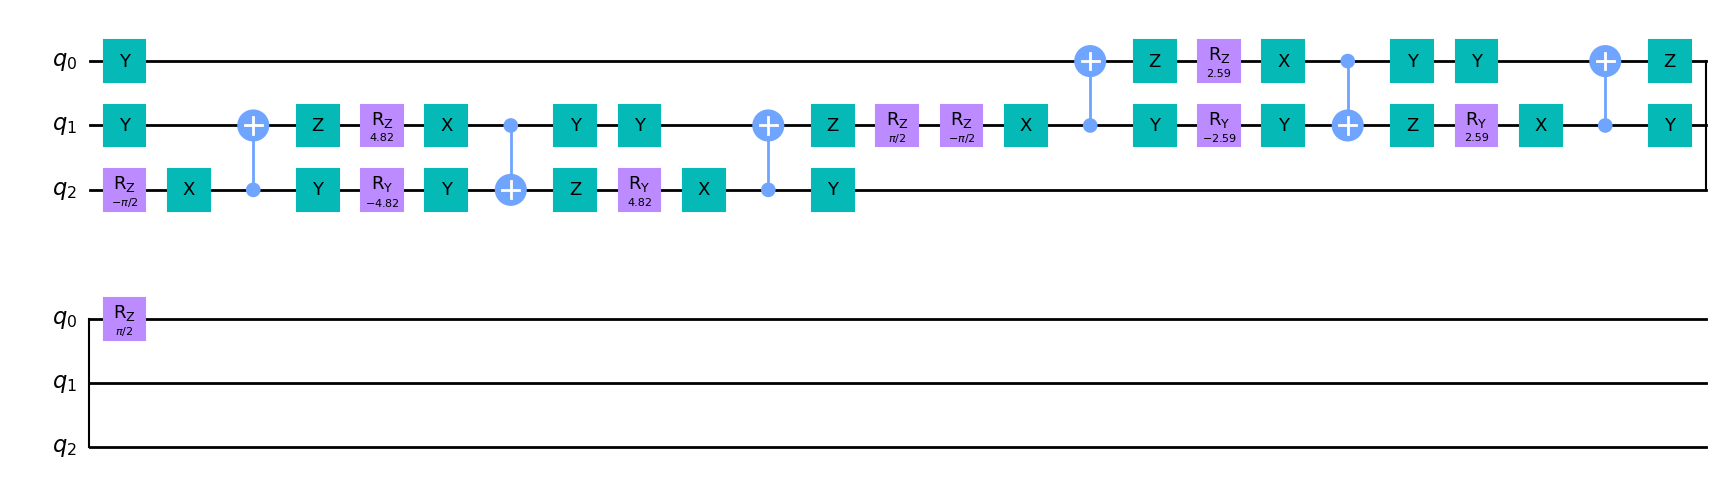

In [54]:
U_v = AnsatzCircuit(np.array([2.0425250870377347,6.496045992178892]), 1)
U_v = TwirlCircuit(U_v)
U_v.draw(output='mpl')